# Red-black search trees

In this notebook we will explore search trees. We will work from the implementation in the search tree note, but ignore the `delete` function.

In [1]:
class TreeNode:
    def __init__(self, value, left = None, right = None):
        self.value = value
        self.left = left
        self.right = right
        
def display_tree(tree):
    if tree is None:
        return ""
    if tree.left is None and tree.right is None:
        return str(tree.value)
    
    if tree.left is None:
        subtree = "({right})".format(right = display_tree(tree.right))
    elif tree.right is None:
        subtree = "({left})".format(left = display_tree(tree.left))
    else:
        subtree = "({left},{right})".format(left = display_tree(tree.left),
                                            right = display_tree(tree.right))
    return "{subtree}{value}".format(subtree = subtree, value = tree.value)

def insert(tree, value):
    if tree is None:
        return TreeNode(value)
    else:
        if tree.value == value:
            return tree
        elif tree.value < value:
            return TreeNode(tree.value, tree.left, insert(tree.right, value))
        else:
            return TreeNode(tree.value, insert(tree.left, value), tree.right)
        
def member(tree, value):
    if tree is None:
        return False
    if tree.value == value:
        return True
    if tree.value < value:
        return member(tree.right, value)
    else:
        return member(tree.left, value)

In [2]:
tree = None
for i in range(10):
    tree = insert(tree, i)
print(display_tree(tree))

(((((((((9)8)7)6)5)4)3)2)1)0


The time it takes to do `insert` and `member` operations depend on the size and the shape of a search tree. In the worst case, both will have to traverse the longest path from root to a leaf. How long this path is, depends on how the tree was constructed--in particular it depends on the order in which we inserted elements. We can observe this if we consider two different approaches to building trees over the same sequence of elements, one that inserts the element in increasing order, and one that inserts them in a random order

In [3]:
def tree_depth(tree):
    if tree is None:
        return 0
    return 1 + max(tree_depth(tree.left), tree_depth(tree.right))

def build_tree(values):
    tree = None
    for v in values:
        tree = insert(tree, v)
    return tree

def sequential_tree_size(n):
    return tree_depth(build_tree(range(n)))

from numpy.random import permutation
def random_tree_size(n):
    return tree_depth(build_tree(permutation(n)))

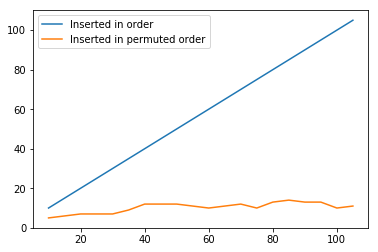

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

ns = list(range(10,110,5))

fig, ax = plt.subplots()
ax.plot(ns, [sequential_tree_size(n) for n in ns], label = "Inserted in order")
ax.plot(ns, [random_tree_size(n) for n in ns], label = "Inserted in permuted order")
ax.legend(loc='upper left')

When we insert the elements in sorted order, we get a maximally unbalanced tree. Each new element has to be inserted as the rightmost element in the new tree, and the result is a tree that consists of one long chain of nodes going to the right. If we inserted elements in the reverse order, we would get a similar tree that was left-heavy instead.

If we insert elements in random order, we alleviate this problem. We will, in fact, expect to get a reasonably balanced tree. Since a balanced tree of size $n$ has a depth in $O(\log n)$, the `insert` and `member` operations are much faster for balanced trees. Of course, since the actual depth depends on the random permutation, and since the $\log n$ optimal depth is only achieved for perfectly balanced trees, we expect the depth to be slightly higher than $\log n$, but our goals for this notebook is to implement a version of search trees that has worst-case depth between $\log n$ and $2\lceil\log(n)\rceil$.

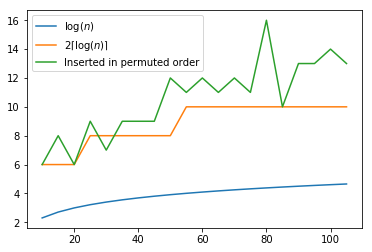

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from math import log, ceil

ns = list(range(10,110,5))

fig, ax = plt.subplots()
ax.plot(ns, [log(n) for n in ns], label = r"$\log(n)$")
ax.plot(ns, [2*ceil(log(n)) for n in ns], label = r"$2\lceil\log(n)\rceil$")
ax.plot(ns, [random_tree_size(n) for n in ns], label = "Inserted in permuted order")
ax.legend(loc='upper left')

## Red-black search trees



In [6]:
RED = 0
BLACK = 1

class TreeNode:
    def __init__(self, value, colour = RED, left = None, right = None):
        self.value = value
        self.colour = colour
        self.left = left
        self.right = right

def insert_recursion(tree, value):
    if tree is None:
        return TreeNode(value)
    else:
        if tree.value == value:
            return tree
        elif tree.value < value:
            return rebalance(TreeNode(tree.value, tree.colour, tree.left, insert_recursion(tree.right, value)))
        else:
            return rebalance(TreeNode(tree.value, tree.colour, insert_recursion(tree.left, value), tree.right))

def insert(tree, value):
    tree = insert_recursion(tree, value)
    tree.colour = BLACK
    return tree

![](figures/RBT-transformations.png)

In [7]:
def rebalance(tree):
    is_match, a, b, c, d, x, y, z = match_tree_pattern(tree)
    if is_match:
        return TreeNode(y, colour = RED, 
                        left = TreeNode(x, colour = BLACK, left = a, right = b),
                        right = TreeNode(z, colour = BLACK, left = c, right = d))
    else:
        return tree

In [8]:
def match_tree_pattern(tree):
    if tree is not None and tree.left is not None and tree.left.right is not None and \
        tree.colour == BLACK and tree.left.colour == RED and tree.left.right.colour == RED:
            x, y, z = tree.left.value, tree.value, tree.left.right.value
            a, b = tree.left.left, tree.left.right.left
            c, d = tree.left.right.left, tree.right
            return True, a, b, c, d, x, y, z
        
    # Implement the other three matches
    
    return False, None, None, None, None, None, None, None


def match_tree_pattern(tree):
    if tree is not None and tree.left is not None and tree.left.right is not None and \
        tree.colour == BLACK and tree.left.colour == RED and tree.left.right.colour == RED:
            x, y, z = tree.left.value, tree.value, tree.left.right.value
            a, b = tree.left.left, tree.left.right.left
            c, d = tree.left.right.left, tree.right
            return True, a, b, c, d, x, y, z
        
    if tree is not None and tree.left is not None and tree.left.left is not None and \
        tree.colour == BLACK and tree.left.colour == RED and tree.left.left.colour == RED:
            x, y, z = tree.left.left.value, tree.left.value, tree.value
            a, b = tree.left.left.left, tree.left.left.right
            c, d = tree.left.right, tree.right
            return True, a, b, c, d, x, y, z

    if tree is not None and tree.right is not None and tree.right.right is not None and \
        tree.colour == BLACK and tree.right.colour == RED and tree.right.right.colour == RED:
            x, y, z = tree.value, tree.right.value, tree.right.right.value
            a, b = tree.left, tree.right.left
            c, d = tree.right.right.left, tree.right.right.right
            return True, a, b, c, d, x, y, z

    if tree is not None and tree.right is not None and tree.right.left is not None and \
        tree.colour == BLACK and tree.right.colour == RED and tree.right.left.colour == RED:
            x, y, z = tree.value, tree.right.value, tree.right.left.value
            a, b = tree.left, tree.right.left.left
            c, d = tree.right.left.right, tree.right.right
            return True, a, b, c, d, x, y, z

    return False, None, None, None, None, None, None, None

In [9]:
ns = permutation(10)
tree = None
for n in ns:
    tree = insert(tree, n)
for n in ns:
    if not member(tree, n):
        print(n, "is missing from", display_tree(tree))

5 is missing from (((0,2)1,3)4,((8)5,7)9)6
3 is missing from (((0,2)1,3)4,((8)5,7)9)6
7 is missing from (((0,2)1,3)4,((8)5,7)9)6


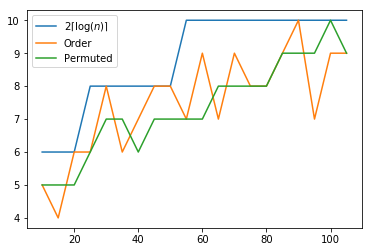

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from math import log, ceil

ns = list(range(10,110,5))

fig, ax = plt.subplots()
ax.plot(ns, [2*ceil(log(n)) for n in ns], label = r"$2\lceil\log(n)\rceil$")
ax.plot(ns, [sequential_tree_size(n) for n in ns], label = "Order")
ax.plot(ns, [random_tree_size(n) for n in ns], label = "Permuted")
ax.legend(loc='upper left')